In [ ]:
import gymnasium as gym 
from gymnasium import spaces 
import numpy as np 
import math 
import matplotlib.pyplot as plt

class TwoD_Robot(gym.Env): 
    def __init__(self):
        
        # stuff for training 
        self.max_episode_steps = 25000
        self.current_step = 0 
                
        # length of robot link    
        self.L1 = 42.5 
        self.L2 = 39.22 
        self.L3 = 9.97
        
        #initial robot motor angles and endeffektor pose  
        self.theta = np.array([0.0,0.0,0.0])
        self.ee_pose = self.forward_kinematics(self.theta)
        self.dist_to_goal = 100
        self.angle_distance = 0
        
        # random goal initializeation
        self.goal = np.array([0,30,np.pi])
        
        # Action space: motorangles 
        self.action_space = spaces.Box(low= -0.5, high = 0.5, shape = (3,))
       
        # endeffektor pose, joint angles, goal, distance to goal space definition  
        self.observation_space = spaces.Dict(
            {
                "pose": spaces.Box(
                        low = np.array([-100,-100,-2*np.pi]),
                        high =np.array([100,100,2*np.pi]), 
                        dtype = float
                    ), 
                "motors": spaces.Box(
                        low = np.array([-np.pi, -np.pi, -np.pi]),
                        high =np.array([ np.pi, np.pi, np.pi]),
                        dtype = float
                    ),
                 "goal": spaces.Box(
                        low = np.array([-100,-100,-np.pi]),
                        high =np.array([100,100,np.pi]), 
                        dtype = float
                    ),
                "distance": spaces.Box(
                        low = np.array([0,0]),
                        high = np.array([200, 2*np.pi]),
                        dtype = float
                    )    
            } 
        )


    # function that returns ee_pose from given motorangles 
    def forward_kinematics(self,theta):
        """compute Endeffector Pose and returns x,y and theta (angles). zero pose is a vertical line"""
        x = (self.L1 * np.sin(theta[0]) +
            self.L2 * np.sin(theta[0] + theta[1]) +
            self.L3 * np.sin(theta[0] + theta[1] + theta[2]))
        y = (self.L1 * np.cos(theta[0]) +
            self.L2 * np.cos(theta[0] + theta[1]) +
            self.L3 * np.cos(theta[0] + theta[1] + theta[2]))
        theta_E = theta[0] + theta[1] + theta[2]
        return np.array([x,y,theta_E])
         
    # get observation / current state as dict with ee_pose, motorangles, goal, distance to goal 
    def _get_obs(self):
        self.ee_pose = self.forward_kinematics(self.theta)
        self.dist_to_goal = np.linalg.norm(self.ee_pose[:2] - self.goal[:2])
        self.angle_distance = np.abs(np.abs(self.ee_pose[2] - self.goal[2]))
        dist_total = np.array([self.dist_to_goal, self.angle_distance])
    
        observation = {
            "pose": self.ee_pose,
            "motors": self.theta,
            "goal": self.goal, 
            "distance": dist_total
        }
       
        return observation
    
    #return empty dict
    def _get_info(self):
        info= {    
        } 
        return info   
    
    #return reward    
    def _get_reward(self):
        # distance reward
        r_d = 500/self.dist_to_goal 
        r_a = -0.1* self.angle_distance / np.pi *0
        
        # reward for keeping away from smashing the motors
        r_edge = - self.theta[0]**2 - self.theta[1]**2 - self.theta[2]**2
        # reward if done 
        r_done = 0 
        if (self.dist_to_goal < 5):
            r_done = 1000 - self.current_step
        
        # print("r_edge:",r_edge)
        # print("r_d:", r_d)
        # print("r_done", r_done)
        reward = r_d + r_a + r_done + r_edge           
        return reward        

    # set the robot to random state and defines new goal, returns new observation  and info(empty) 
    def reset(self, seed = None, options = None):
        #returns new random state and emptyinfo 
        # We need the following line to seed self.np_random
        super().reset(seed=seed)
        

        #self.np_random, _ = gym.utils.seeding.np_random(seed)
        self.theta = np.random.uniform(-np.pi, np.pi, size = 3)
        
        #set new goal 
        rad = np.sqrt(np.random.uniform(0,1))* 60
        angle = np.random.uniform(-np.pi,np.pi)
        x = rad * np.cos(angle)
        y = rad * np.sin(angle)
        theta_e = np.random.uniform(-np.pi,np.pi)         
        self.goal = np.array([x,y,theta_e])
        
        print("reset, goal: ", self.goal)

        #get observation and info 
        observation = self._get_obs()
        info = self._get_info()
        return observation, info 
      
    def check_done (self):
        done = False
        reason= '?'
        if (self.dist_to_goal < 5):
            done = True
            reason = 'goal reached'
            
        if (self.current_step>= self.max_episode_steps): 
            done = True
            self.current_step = 0 
            reason = 'max_episodes reached'
        else: 
            self.current_step += 1 
                   
        if done: 
            print("done,", reason)
        return done 
        
    #returns observation, reward, done = bool, truncated = False, info = empty  
    def step(self,action):
        # perform action and oberve 
        self.theta += action
        self.theta = np.clip(self.theta, -np.pi, np.pi)  # Keep angles in range
        self.ee_pose = self.forward_kinematics(self.theta)
    
        #observe
        observation = self._get_obs()
        reward = self._get_reward()
        done = self.check_done()
        truncated = False
        info = self._get_info()          
        return observation, reward, done, truncated, info 

    # redenring without returning anything 
    def render(self):
        goal = self.goal
        angles = self.theta
        links = np.array([self.L1,self.L2,self.L3])
        #calc end of each Link
        Ey1 = math.cos(angles[0])*links[0]
        Ex1 = math.sin(angles[0])*links[0]
        Ey2 = math.cos(angles[0]+angles[1])*links[1] + Ey1
        Ex2 = math.sin(angles[0]+angles[1])*links[1] + Ex1
        Ey3 = math.cos(angles[0]+angles[1]+ angles[2]) * links[2] + Ey2
        Ex3 = math.sin(angles[0]+angles[1]+angles[2]) * links[2] + Ex2 

        joints = np.array([[0,Ex1,Ex2,Ex3],[0,Ey1,Ey2,Ey3]])
        dist_to_goal = np.array(np.linalg.norm(self.ee_pose[:2] - self.goal[:2]))

        print("distance:", dist_to_goal)
        print("theta:", self.theta)
        fig = plt.figure()
        plt.ion()
        plt.plot(joints[0],joints[1], '-o')
        plt.plot(goal[0],goal[1], 'x', markersize = 8, color = 'r' )
        fig.canvas.draw
        fig.canvas.flush_events()

# Test Environment 

2024-12-19 17:47:12.919343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734601632.932822 1411291 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734601632.936776 1411291 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-19 17:47:12.952910: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


reset, goal:  [12.40879161 37.3210104   1.00915922]
reset, goal:  [-27.42855548   5.69247458   0.50194984]
reset, goal:  [-41.85615626   4.03378265  -0.6497243 ]
Using cuda device
Wrapping the env in a DummyVecEnv.


/home/cecily/MasterThesis_Cy/venv/lib/python3.10/site-packages/stable_baselines3/common/env_checker.py:461: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


reset, goal:  [48.46370692 -5.60790149  3.0708972 ]
done, goal reached
reset, goal:  [ 20.30179259 -11.80481806  -2.28204935]
done, goal reached
reset, goal:  [ 17.02780479 -28.00472352   1.14935645]
done, goal reached
reset, goal:  [-12.55020725   1.38971336  -1.46200427]
done, goal reached
reset, goal:  [  9.45133207 -26.78271297  -0.45089028]
done, goal reached
reset, goal:  [-13.20508745  26.91162783   2.82161104]
done, goal reached
reset, goal:  [32.0803777  46.83372506 -1.97845309]
done, goal reached
reset, goal:  [-52.32874572   9.73145798  -0.51494647]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 145      |
|    ep_rew_mean     | 726      |
| time/              |          |
|    fps             | 1056     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
done, goal reached
reset, goal:  [-32.19827585 -14.87996133  -1.32163024]
done, goal reached


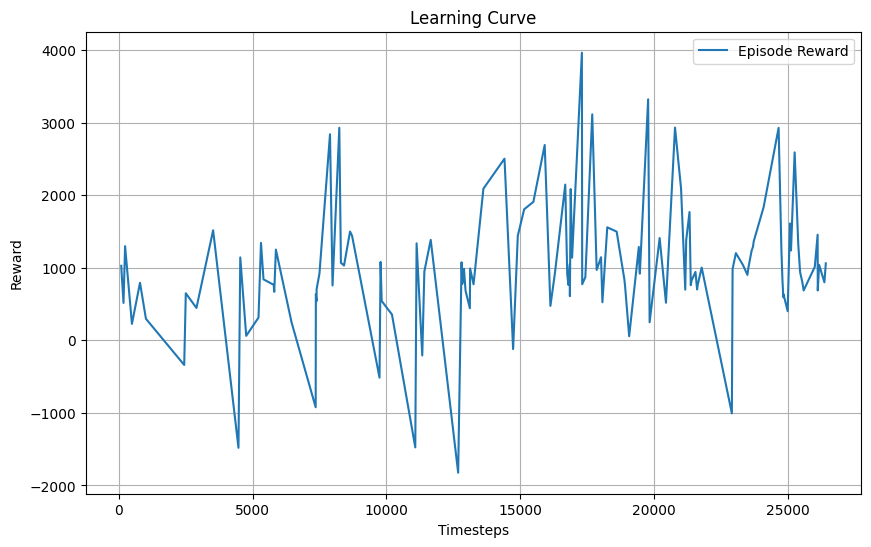

In [2]:
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO, SAC      
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
import pandas as pd   # to read files 
                                                                                                                             
env = TwoD_Robot()
# check if environmnet is working properly 
check_env(env)

env = Monitor(env,filename="monitor_logs/")

# training                                                                                   
model = PPO(policy = "MultiInputPolicy", env= env, ent_coef=0.01, verbose=1)                                 
model.learn(total_timesteps=25000)                                                                                                                                              
model.save("ppo_2DRobot")  # saving the model to ppo_cartpole.zip         

# Load the logs
log_data = pd.read_csv("monitor_logs/monitor.csv", skiprows=1)
# Extract episode rewards and timesteps
timesteps = log_data["l"].cumsum()  # Cumulative timesteps
episode_rewards = log_data["r"]  # Rewards
  
plt.figure(figsize=(10, 6))
plt.plot(timesteps, episode_rewards, label="Episode Reward")
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.title("Learning Curve")
plt.legend()
plt.grid()
plt.show()
  

In [ ]:
                                                                                                                                                                                                                                                   
env = TwoD_Robot()
# check if environmnet is working properly 
check_env(env)

env = Monitor(env,filename="monitor_logs/")
      
# Initialize the PPO model
model = PPO(policy = "MultiInputPolicy", env= env, ent_coef=0.01, verbose=1)                                 
# Custom training loop with rendering
total_timesteps = 10000
steps_per_render = 10  # Render every 100 steps
obs, info = env.reset()

for step in range(total_timesteps):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, done ,truncated, info = env.step(action)

    # Render at specified intervals
    if step % steps_per_render == 0:
        env.render()
    # Reset the environment if done
    if done:
        obs, info = env.reset()
env.close()


In [ ]:
#testing
model = PPO.load("ppo_2DRobot")  # loading the model from ppo_cartpole.zip             
print("finished loading")                                                                                        

rewards = []
n_episodes = 10 
for episode in range(n_episodes):
    obs, info = env.reset()
    episode_rewards = 0
    done = False
    step = 0
    print(f"Starting Episode {episode + 1}")
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        env.render()  # Optional: visualize the environment
        episode_rewards += reward
        step += 1
        
        #print(f"Episode {episode + 1}, Step {step}, Reward: {reward}")
    
    print(f"Episode {episode + 1} finished with total reward: {episode_rewards}")
    
    rewards += episode_rewards

print(f"Mean reward over {n_episodes} episodes: {rewards / n_episodes}")